# Cell population simulation: wild type has growth advantage over mutant

Summary of code:
1) Define cell object to record 

    - self index
    - index of parent
    - birth time
    - plasmid count at birth
    - steady state plasmid count
    - division time (dependent on existence of plasmids) <p>&nbsp;</p>
    
2) Simulate population starting with 1 cell at time 0 with a nonzero number of plasmids

    - Calculate steady state plasmid number. **Assume that plasmid distribution reaches steady state before division**. 
        + If initial plasmid count is 0, steady state plasmid count is 0
        + If initial plasmid count > 0, steady state plasmid count is sampled from the distribution Binom([max plasmid number n], 0.5)
            *Question: This means that a cell can lose plasmids entirely - should I choose a different distribution? <p>&nbsp;</p>
        
    - Partition plasmids to two daughter cells.
        + Number of plasmids in daughter 1: sample from Binom([steady state plasmid number], 0.5)
        + Number of plasmids in daughter 2: [steady state plasmid number]-[daughter 1 plasmid number] <p>&nbsp;</p>
    
    - Create two new daughter cells.
        + Birth times are the current cell's division time
        + Division time is [birth time] + a_m if they have 0 plasmids, and [birth time] + a_w if they have more than 0 plasmids <p>&nbsp;</p>

    - Remove current cell from queue of cells to process; add daughter cells. Sort the queue by division time so that the next cell to divide is processed in the next loop <p>&nbsp;</p>

3) I store all cells that have already divided in a list called "cells", and I store all cells in the queue, aka the currently alive population, in a list called "Q". 
    



In [1]:
import numpy as np
import random as rand
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class cell:
    def __init__(self,index,parent,birth,init_plasmid,tau):
        '''Initializes cell attributes
        param:: index: cell index
        param:: parent: index of parent cell
        param:: birth: birth time
        param:: init_plasmid: plasmids partitioned to cell at birth
        param:: tau: growth rate
        return:: None
        '''
        self.index=index
        self.parent = parent
        self.birth = birth
        self.init_plasmid = init_plasmid
        self.ss_plasmid = 100 #placeholder number; will calculate steady state plasmid number later
        self.div = birth+tau
        
def count_plasmid_cells(Q):
    cells_with_plasmids = 0
    cells_without_plasmids = 0

    for cell in Q:
        if cell.init_plasmid > 0:
            cells_with_plasmids += 1
        else:
            cells_without_plasmids += 1
    
    return cells_with_plasmids, cells_without_plasmids

In [23]:
def simulation(Nmax, keep, a_w, a_m, n, p):
    count=0
    init_plasmid=1 #initial plasmid number of first cell. Arbitrary- just can't be 0
    #c= cell(0,[],0,init_plasmid,a_w)   #cell(index,parent,birth,initialplasmid,tau)
    
    cells_with_plasmids_history = []
    cells_without_plasmids_history = []
    
    Q=[] # initialize queue of cells that have not divided yet (currently alive cells)
    for i in range(keep):
        Q.append(cell(i, [], 0, init_plasmid, np.random.uniform(0,a_w))) #cell(index,parent,birth,initialplasmid,tau)
        #note: division time = birth + tau. 
        #I initialize cells so they will divide at some point between 0 and a_w time units in the future
        #so for the initialized cells, their age at the begining of the simulation is a_w - Q[i].div
   
    cells=[] #list of cells that have divided already
    N=keep-1 #indices taken by initialized cell population

    while len(cells)<Nmax:
        #sort Q so Q[0] is next cell to divide
        Q=sorted(Q,key=lambda x: x.div, reverse=False)
        
        #assign current cell to simulate
        current=Q[0]

        #Calculate steady state plasmid number
        if current.init_plasmid==0:
            d1_plasmids=0
            d2_plasmids=0
        else:
            ss_plasmid_num=np.random.binomial(n,p,size=None)
            current.ss_plasmid=ss_plasmid_num

            #Partition plasmids between two daughter cells
            d1_plasmids=np.random.binomial(ss_plasmid_num,p,size=None)
            d2_plasmids=ss_plasmid_num-d1_plasmids
            if d1_plasmids == 0 or d2_plasmids == 0:
                count=count+1
        
            

        #Create two new daughter cells
        if d1_plasmids==0:
            daughter1=cell(N+1, current.index, current.div, d1_plasmids, a_m) #index,parentindex,birth,initialplasmids,tau
        else:
            daughter1=cell(N+1, current.index, current.div, d1_plasmids, a_w) #index,parentindex,birth,initialplasmids,tau
        if d2_plasmids==0:
            daughter2=cell(N+2, current.index, current.div, d2_plasmids, a_m) #index,parentindex,birth,initialplasmids,tau
        else:
            daughter2=cell(N+2, current.index, current.div, d2_plasmids, a_w) #index,parentindex,birth,initialplasmids,tau
    
        #Add current cell to vector 'cells'
        cells.extend([current])
    
        #####To keep cell population at a fixed number by removing one cell after each division
        ##### once the population reaches a certain size, include this section:
        #keep=1000
        if len(Q)>=keep:
            rem_cells = rand.sample(Q[1:],1)  #cells to be removed (does not include current or daughters)  
            new_Q = [x for x in Q if x not in rem_cells]
            Q = new_Q.copy()
        
        
        ########
        # Count the number of cells with and without plasmids in the current population
        cells_with_plasmids, cells_without_plasmids = count_plasmid_cells(Q)

        # Append the current counts to the history lists
        cells_with_plasmids_history.append(cells_with_plasmids)
        cells_without_plasmids_history.append(cells_without_plasmids)

        #Update index for next time
        N+=2

        #Update Q for next time - remove current cell, add daughter cells
        Q.remove(current)
        Q.extend([daughter1,daughter2])
        
    return Q, cells, cells_with_plasmids_history, cells_without_plasmids_history, count

In [72]:
Nmax=100000 #number of cells processed by simulation
keep=4000
a_w=.8 #wild type mean lifetime (note: the population with the shorter lifetime has the advantage)
a_m=1 #0 plasmid mean lifetime
n=20 #max number of plasmids
p=.5 #probability of success in binomial distribution; used to calculate steady state plasmid num and also 
     #daughter plasmid partitioning


(array([ 70.,  74., 291., 490., 760., 789., 688., 434., 231., 128.,  32.,
         11.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <BarContainer object of 20 artists>)

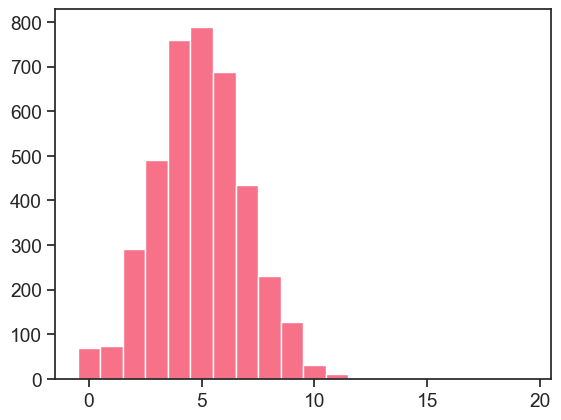

In [73]:
Q, cells,cells_with_plasmids_history, cells_without_plasmids_history,count = simulation(Nmax, keep, a_w, a_m, n, p)
Q_init=[]
for i in Q:
    Q_init.extend([i.init_plasmid])
plt.hist(Q_init,bins=n, range=[-.5,19.5])


In [74]:
count/Nmax #approximate empirical ploss

0.0061

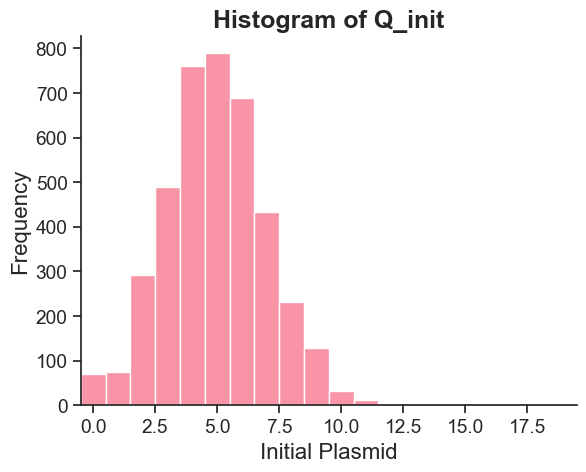

In [75]:
# Set Seaborn's style without grid lines
sns.set_style("ticks")

# Set custom colors and fonts
custom_palette = sns.color_palette("husl", 1)
sns.set_palette(custom_palette)
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})

# Create the plot
ax = sns.histplot(Q_init, bins=n, kde=False, color=custom_palette[0], discrete=True)
sns.despine()  # Remove the top and right spines of the plot
plt.xlim(-0.5, 19.5)  # Set the x-axis range

# Set title, x-axis label, and y-axis label
ax.set_title("Histogram of Q_init", fontsize=18, fontweight='bold')
ax.set_xlabel("Initial Plasmid", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)

plt.show()

In [76]:
ploss=0.00634147 #theoretical


In [77]:
def plot_plasmid_counts(cells_with_plasmids_history, cells_without_plasmids_history):
    division_times = list(range(len(cells_with_plasmids_history)))

    # Calculate the ratio of cells with and without plasmids
    ratio_history = [y / (x+y) if y != 0 else 0 for x, y in zip(cells_with_plasmids_history, cells_without_plasmids_history)]

    # Set Seaborn's style
    sns.set_style("ticks")
    
    # Plot the number of cells with and without plasmids
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=division_times, y=cells_with_plasmids_history, label="Cells with Plasmids", color='blue')
    sns.lineplot(x=division_times, y=cells_without_plasmids_history, label="Cells without Plasmids", color='red')
    sns.despine()
    plt.xlabel("Division Time")
    plt.ylabel("Number of Cells")
    plt.title("Number of Cells with and without Plasmids vs. Division Time")
    plt.legend()
    plt.show()

    # Plot the ratio of cells with and without plasmids
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=division_times, y=ratio_history, color='purple')
    sns.lineplot(x=division_times, y=[((-1+2**(x*((ploss-1)/a_w+1/a_m)))*ploss*a_m)/(a_w+a_m*(-1+ploss*2**(x*((ploss-1)/a_w+1/a_m)))) for x in division_times], label = "Graph")
    sns.despine()
    plt.xlabel("Division Time")
    plt.ylabel("Ratio (without Plasmids / (with + without))")
    plt.title("Proportion of plasmid free cells vs. Division Time")
    plt.show()



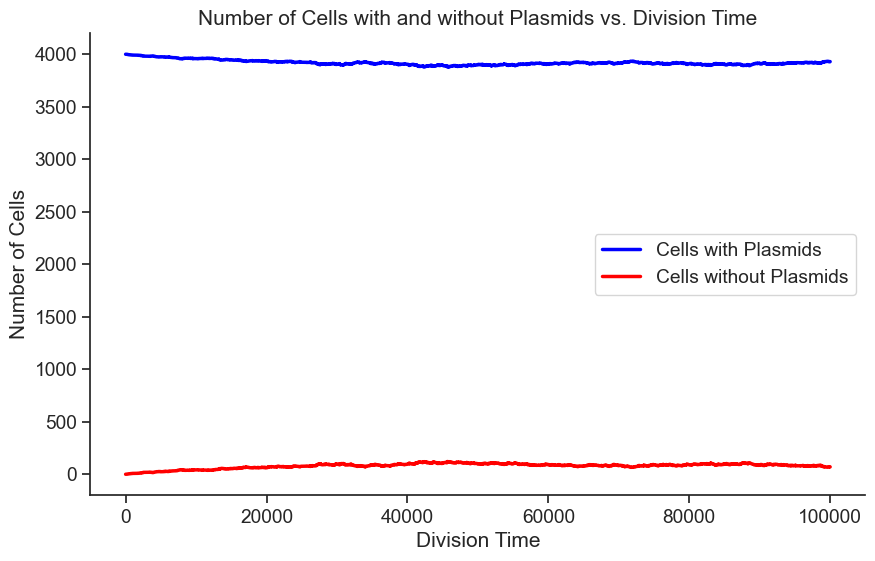

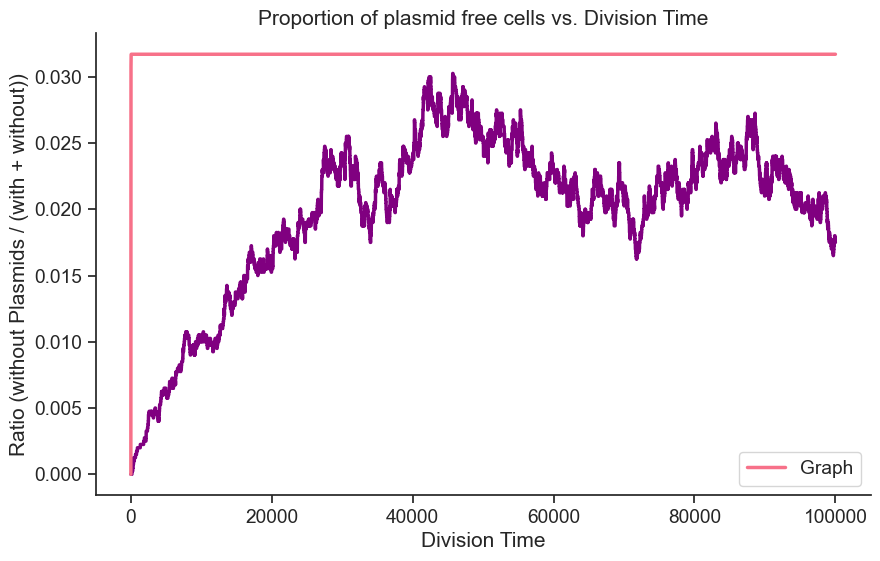

In [78]:
plot_plasmid_counts(cells_with_plasmids_history, cells_without_plasmids_history)

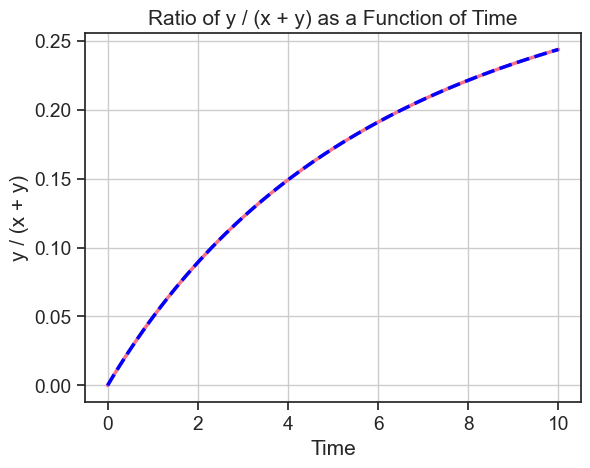

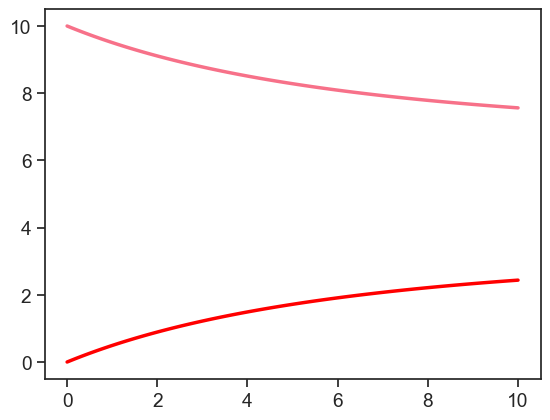

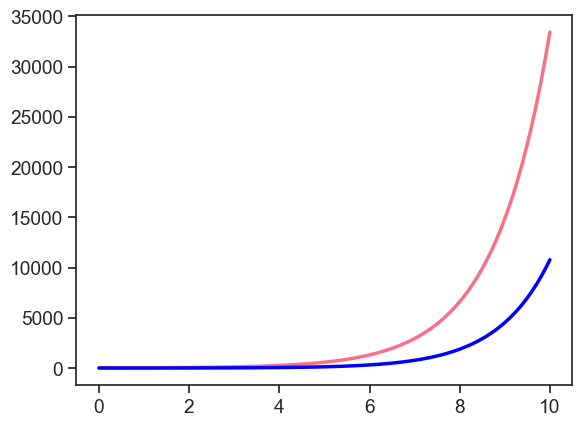

In [222]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Function defining the system of differential equations
def system(variables, t, Tx, Ty, mu):
    x, y = variables
    dxdt = (np.log(2) / Tx) * x - (np.log(2) / Tx) * mu * x - ((np.log(2) / Tx) * x + (np.log(2) / Ty) * y) * (x / (x + y))
    dydt = (np.log(2) / Tx) * mu * x + (np.log(2) / Ty) * y - ((np.log(2) / Tx) * x + (np.log(2) / Ty) * y) * (y / (x + y))
    return [dxdt, dydt]

def system_inf(variables, t, Tx, Ty, mu):
    x, y = variables
    dxdt = (np.log(2) / Tx) * x - (np.log(2) / Tx) * mu * x
    dydt = (np.log(2) / Tx) * mu * x + (np.log(2) / Ty) * y 
    return [dxdt, dydt]

# Parameters
Tx = 0.8
Ty = 1.0
mu = 0.0634147

# Initial conditions
x0 = 10.0
y0 = 0.0
initial_conditions = [x0, y0]

# Time points for integration
t = np.linspace(0, 10, 100)

# Solve the system of differential equations
solution = odeint(system, initial_conditions, t, args=(Tx, Ty, mu))
solution2 = odeint(system_inf, initial_conditions, t, args=(Tx, Ty, mu))

# Extract the solutions for x and y
x = solution[:, 0]
y = solution[:, 1]

xinf=solution2[:,0]
yinf=solution2[:,1]


# Calculate y / (x + y)
ratio = y / (x + y)
ratioinf=yinf/(xinf+yinf)

# Plot the ratio as a function of time
plt.plot(t, ratio)
plt.plot(t,ratioinf,'--',color='blue')
plt.xlabel('Time')
plt.ylabel('y / (x + y)')
plt.title('Ratio of y / (x + y) as a Function of Time')
plt.grid(True)
plt.show()

plt.plot(t,x)
plt.plot(t,y,color='red')
plt.show()

plt.plot(t,xinf)
plt.plot(t,yinf,color='blue')
plt.show()